## Experiment to determine prior regularization `coef_scale`

This notebook assumes you have run
```sh
make update
make preprocess
python mutrans.py --vary-coef-scale=0.01,0.02,0.05,0.1,0.2,0.5
```

In [82]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from pyrocov.util import pearson_correlation

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

In [64]:
results = torch.load("results/mutrans.vary_coef_scale.pt")
assert len(results) == 3 * 6

In [68]:
collated = defaultdict(dict)
for config, result in results.items():
    holdout = config[-1]
    if holdout:
        holdout = holdout[0][0]
        assert holdout in ("include", "exclude")
    else:
        holdout = None
    coef_scale = float(config[0].split("=")[-1])
    collated[coef_scale][holdout] = {
        "mean": result["mean"]["coef"] / 100,
        "std": result["std"]["coef"] / 100,
    }

In [69]:
for coef_scale, col in collated.items():
    col["pearson"] = pearson_correlation(col["include"]["mean"], col["exclude"]["mean"])

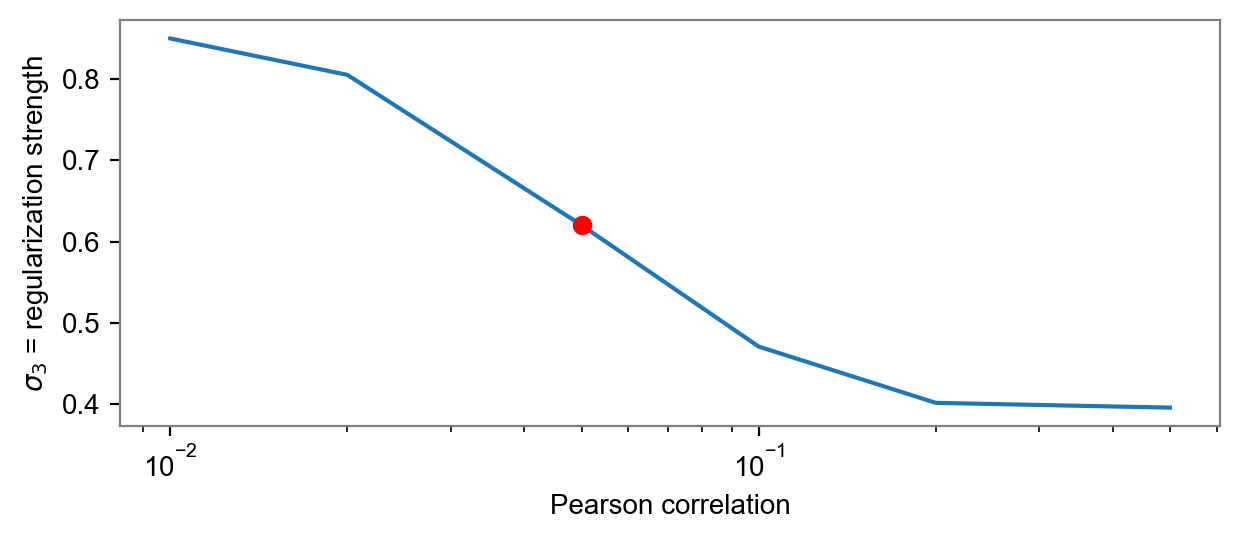

In [113]:
pearson = [float(col["pearson"]) for col in collated.values()]
plt.figure(figsize=(6,2.5))
plt.plot(list(collated), pearson, zorder=-1);
plt.plot([list(collated)[2]], [pearson[2]], "ro", zorder=0)
plt.xscale("log")
plt.xlabel("Pearson correlation")
plt.ylabel("$\sigma_3$ = regularization strength")
plt.tight_layout(pad=0)
plt.savefig("paper/coef_scale_pearson.png")

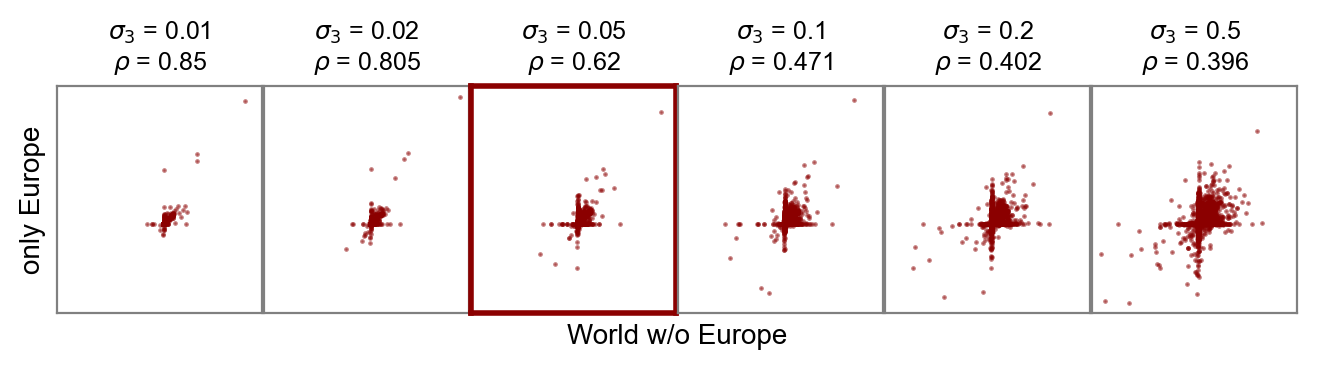

In [103]:
fig, axes = plt.subplots(1, 6, figsize=(8, 1.5), sharey=True, sharex=True)
for ax, (coef_scale, col) in zip(axes, sorted(collated.items())):
    ax.scatter(col["exclude"]["mean"].numpy(), col["include"]["mean"].numpy(),
               0.5, color="darkred", alpha=0.5)
    ax.set_title(f"$\\sigma_3$ = {coef_scale}\n$\\rho$ = {col['pearson']:0.3g}", fontsize=9)
    ax.set_xticks(())
    ax.set_yticks(())
for spine in axes[2].spines.values():
    spine.set_linewidth(2.0)
    spine.set_color("darkred")
    
fig.add_subplot(111, frameon=False)
plt.xticks(())
plt.yticks(())
plt.xlabel("World w/o Europe")
plt.ylabel("only Europe")
plt.subplots_adjust(wspace=0.01)
plt.savefig("paper/coef_scale_scatter.png")

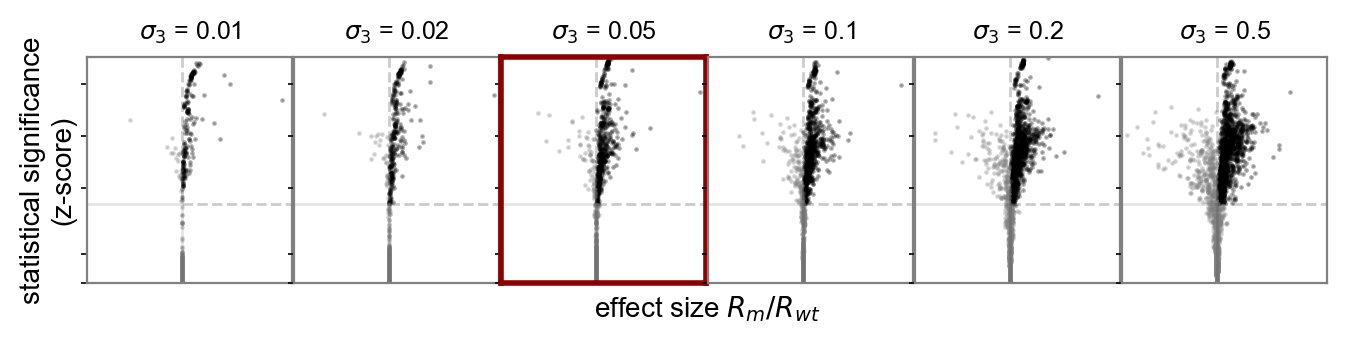

In [107]:
sigma = 5.0
p_sig = dist.Normal(torch.zeros(()).double(),1).cdf(torch.tensor(-sigma).double()).item()
    
fig, axes = plt.subplots(1, 6, figsize=(8, 1.5), sharey=True, sharex=True)
x0 = min(col[None]["mean"].min().item() for col in collated.values()) * 1.05
x1 = max(col[None]["mean"].max().item() for col in collated.values()) * 1.05
y1 = max((col[None]["mean"] / col[None]["std"]).abs().max().item() * 1.05
         for col in collated.values())
for ax, (coef_scale, col) in zip(axes, sorted(collated.items())):
    mean = col[None]["mean"]
    std = col[None]["std"]
    z = (mean / std).abs()
    ok = (mean > 0) & (z > sigma)
    ax.scatter(mean[ok].numpy(), z[ok].numpy(), 0.5, color="black", alpha=0.3)
    ax.scatter(mean[~ok].numpy(), z[~ok].numpy(), 0.5, color="gray", alpha=0.3)
    ax.set_title(f"$\\sigma_3$ = {coef_scale}", fontsize=9)
    ax.set_yscale("symlog")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlim(x0, x1)
    ax.set_ylim(0, y1)
    
    ax.plot([0, 0, x1], [y1, sigma, sigma], 'k--', lw=1, alpha=0.2)
    ax.plot([x0, 0, 0], [sigma, sigma, 0], 'k-', lw=1, alpha=0.1)
for spine in axes[2].spines.values():
    spine.set_linewidth(2.0)
    spine.set_color("darkred")

fig.add_subplot(111, frameon=False)
plt.xticks(())
plt.yticks(())
plt.xlabel("effect size $R_m/R_{wt}$")
plt.ylabel("statistical significance\n(z-score)")
plt.subplots_adjust(wspace=0.01)
plt.savefig("paper/coef_scale_volcano.png")